In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import collections
import itertools

from sklearn import datasets, metrics, svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Projet SML

In this notebook, we're going to review three different models for modeling opinions on movie reviews.<br>
We first need to load the data, and then, represent it into numerical values.<br>
We will use the three following models:<br>

    Logistic Regression
    Random Forests
    SVM
    
We will also compare the different models and try to find parameters that increase their performance.

# Loading data

Data is located under the data directory, we use the smaller sample for now.

In [25]:
# importing data from the data folder
# one subfolder represents one class
dataOpinions = datasets.load_files("data/txt_sentoken")

X = dataOpinions.data
Y = dataOpinions.target

# creating training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1)

# classes associated to files (1=pos 0=neg)
# print(dataOpinions.target_names)  # class names
# print(dataOpinions.target[:50])   
# print(dataOpinions.filenames)     # file names associated to comments


## Data distribution

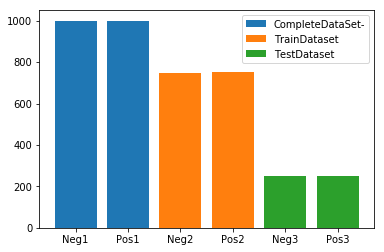

In [26]:
plt.bar(["Neg1","Pos1"],[collections.Counter(Y)[0],collections.Counter(Y)[1]],label="CompleteDataSet-")
plt.bar(["Neg2","Pos2"],[collections.Counter(Y_train)[0],collections.Counter(Y_train)[1]],label="TrainDataset")
plt.bar(["Neg3","Pos3"],[collections.Counter(Y_test)[0],collections.Counter(Y_test)[1]],label="TestDataset")
plt.legend(loc='upper right')
plt.show()

As we can see, the distrubution is made of 2000 examples, half of them are positive, and the other, negative.<br>
The distrubution for the training and test sets we just computed also respect this distribution.<br>
Keeping the same proportion of categories in the different sets is important to keep representative samples.

# Preparing the models

## Construction with pipeline
<br/>
We use a pipeline to tune parameters and fine the optimal ones easily.<br/>
CountVectorizer transforms texts into numerical vectors.<br/>
TfidfTransformer tries to weight data according to the length of the text (TF) and according to the frequency of terms across each text (IDF).

#### Construction of Logistic Regression Pipeline
<br />
We create a gridSearch that will train a logistic regression model with different parameters.<br>
The data will be represented either by 1-grams, or by 1 and 2-grams.<br>
We'll try to use idf or not.<br>
We also test different values of C witch is used for regularisation.<br>
Finally, we'll try to use stop words to remove 'useless' features, or keep them.<br>
After training, we'll take the best model.

In [27]:
logReg_pipeline = Pipeline([('dataVect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('logReg', LogisticRegression()),
                    ])

logReg_parameters = {'dataVect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'logReg__solver': ['lbfgs'],
              'logReg__C':[0.01, 0.1, 1, 10, 100],
              'dataVect__stop_words': ['english',None],
}

logReg_gridSearch = GridSearchCV(logReg_pipeline, logReg_parameters, n_jobs=-1, return_train_score=True, cv=3)


#### Construction of SVM Pipeline
<br/>
Here we build the SVM pipeline and its parameters

In [28]:
svm_pipeline = Pipeline(
        [
            ('dataVect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('SVM', svm.SVC())
        ])

svm_parameters = {
    'tfidf__use_idf' : [True, False],
    'SVM__gamma' : [0.001],
    'SVM__probability': [True],
    'SVM__kernel': ['rbf','linear','poly'],
    'SVM__C' : [1, 1000]
}

svm_gridSearch = GridSearchCV(svm_pipeline, svm_parameters, n_jobs=-1, return_train_score=True, cv=3)

#### Construction of Random Forest Pipeline
<br/>
We try two different split criterions, alons with different numbers of trees in order to find the best parameters.

In [29]:
randomForest_pipeline = Pipeline([('dataVect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('randFor', RandomForestClassifier()),
                    ])

randomForest_parameters = {
    'randFor__n_estimators' : [1, 10, 200, 500],
    'randFor__criterion': ['gini', 'entropy'],
    'dataVect__stop_words': ['english'],
}

randomForest_gridSearch = GridSearchCV(randomForest_pipeline, randomForest_parameters, n_jobs=-1, return_train_score=True, cv=5)

# Logistic Regression

### Training with data and getting optimal parameters using gridsearch

In [15]:
# view the parameters we can modify
# data_logreg_pipeline.get_params()
# pipeline_svm.get_params()

In [30]:
# fit with the training set
%time logReg_gridSearch = logReg_gridSearch.fit(X_train, Y_train)

CPU times: user 3.23 s, sys: 1.34 s, total: 4.57 s
Wall time: 2min 16s


We can see all the different models trained by the grid, and the results:

In [8]:
pandas.DataFrame(logReg_gridSearch.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.303056      0.150761         0.825305        0.160644   
1        1.509694      0.078124         0.504507        0.066524   
2        1.481987      0.161138         0.716437        0.297676   
3        1.378573      0.208457         1.091513        0.151474   
4        1.928953      0.125751         0.551787        0.039628   
5        1.530766      0.267292         0.783090        0.218724   
6        3.153237      0.237728         0.710123        0.212170   
7        2.993631      0.302596         0.735868        0.221307   
8        3.643111      1.058858         1.152328        0.303856   
9        4.361640      0.542984         0.877778        0.257946   
10       2.495197      0.758377         1.330942        0.353308   
11       1.662153      0.150769         0.929179        0.100765   
12       1.885166      0.122528         0.814964        0.106550   
13       1.738273      0.271486         1.169450        0.372965   
14       2.303290      0.444612         0.971659        0.149961   
15       2.503857      0.251630         0.726132        0.132244   
16       3.521579      0.157410         1.804292        0.201669   
17       4.097861      0.263647         1.469378        0.264110   
18       4.511919      1.388721         1.117651        0.628070   
19       4.253647      0.676089         0.875462        0.359010   
20       6.914604      0.181050         1.170690        0.129541   
21       5.681235      1.149622         0.879728        0.226751   
22       5.923525      0.155661         1.380959        0.409720   
23       6.515405      0.232174         1.016854        0.216333   
24       8.203900      1.393475         1.209496        0.222054   
25       9.370653      0.729706         1.434393        0.528823   
26      13.340817      1.197731         1.614776        0.476753   
27      20.835147      3.771765         2.082992        0.302018   
28      20.715358      2.364342         1.896263        0.132728   
29      21.697493      2.209385         1.353963        0.252561   
30      12.247458      0.585122         1.739209        0.398498   
31       9.620984      0.142695         1.438652        0.224174   
32       6.486276      0.235189         2.017176        0.311467   
33       8.020313      0.203618         2.040960        0.453774   
34      10.096249      1.348194         1.632231        0.291187   
35      12.550094      1.751517         3.275367        0.514794   
36      15.755334      1.951047         2.525762        0.428216   
37      23.428832      4.417817         2.622728        0.341412   
38      21.293688      4.074652         2.895890        0.354995   
39      28.057690      4.435664         1.285938        0.544138   

   param_dataVect__ngram_range param_dataVect__stop_words param_logReg__C  \
0                       (1, 1)                    english            0.01   
1                       (1, 1)                    english            0.01   
2                       (1, 1)                    english             0.1   
3                       (1, 1)                    english             0.1   
4                       (1, 1)                    english               1   
5                       (1, 1)                    english               1   
6                       (1, 1)                    english              10   
7                       (1, 1)                    english              10   
8                       (1, 1)                    english             100   
9                       (1, 1)                    english             100   
10                      (1, 1)                       None            0.01   
11                      (1, 1)                       None            0.01   
12                      (1, 1)                       None             0.1   
13                      (1, 1)                       None             0.1   
14                      (1, 1)                       None   

## Testing with the test set and measuring results

We start by predicting opinions on the test set.

In [31]:
%time logReg_predictions = logReg_gridSearch.predict(X_test)

CPU times: user 262 ms, sys: 5.24 ms, total: 268 ms
Wall time: 266 ms


The best model has the following parameters:

In [32]:

print("\nbest params:")
for param_name in sorted(logReg_parameters.keys()):
    print("\t%s: %r" % (param_name, logReg_gridSearch.best_params_[param_name]))



best params:
	dataVect__ngram_range: (1, 1)
	dataVect__stop_words: None
	logReg__C: 10
	logReg__solver: 'lbfgs'
	tfidf__use_idf: True


It is interesting to see that english stopwords have not been chosen.<br>
The C value is the inverse of the regularisation strength. In our case, it is neither the higher nor the lower value.<br>
This is understandable because if the regalurisation strength is too high, we won't take the values into account as it should be, while with a low value, we tend to overfit the data.<br>
Finally, it is preferable to use idf in order not to give too much importance to the terms that appear in a lot of documents.

We can look at the individual metrics (we'll compare them with the other models later):

The confusion matrix of the prediction:

In [86]:
logReg_confusion_matrix = metrics.confusion_matrix(Y_test, logReg_predictions)
pandas.DataFrame(logReg_confusion_matrix)


0    1
0  217   34
1   30  219

In [34]:
print("Accuracy: " + str(metrics.accuracy_score(Y_test,logReg_predictions)))
print("Recall: " + str(metrics.recall_score(Y_test,logReg_predictions)) )
print("Precision; " + str(metrics.precision_score(Y_test,logReg_predictions)) )

Accuracy: 0.872
Recall: 0.8795180722891566
Precision; 0.8656126482213439


# Second model : Random Forest

In [13]:
data_randFor_pipeline = Pipeline([('dataVect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('randFor', RandomForestClassifier()),
                    ])

In [20]:
#data_randFor_pipeline.get_params()

We create the gridsearch and train the models.<br>
We try two different split criterions, alons with different numbers of trees in order to find the best parameters.

In [15]:
parametersRF = {
    'randFor__n_estimators' : [1, 10, 200, 500],
    'randFor__criterion': ['gini', 'entropy'],
    'dataVect__stop_words': ['english'],
}
gs_rf = GridSearchCV(data_randFor_pipeline, parametersRF, n_jobs=-1, return_train_score=True, cv=5)
%time gs_rf = gs_rf.fit(X_train, Y_train)

CPU times: user 8.22 s, sys: 118 ms, total: 8.34 s
Wall time: 46.1 s


In [16]:
%time gs_rf_pred = gs_rf.predict(X_test)

print("\nbest params:")
for param_name in sorted(parametersRF.keys()):
    print("\t%s: %r" % (param_name, gs_rf.best_params_[param_name]))


CPU times: user 487 ms, sys: 0 ns, total: 487 ms
Wall time: 486 ms

best params:
	dataVect__stop_words: 'english'
	randFor__criterion: 'entropy'
	randFor__n_estimators: 500


### Training with data and getting optimal parameters using gridsearch

In [35]:
# fit with the training set
%time randomForest_gridSearch = randomForest_gridSearch.fit(X_train, Y_train)

CPU times: user 7.46 s, sys: 276 ms, total: 7.74 s
Wall time: 43.8 s


We can see all the different models trained by the grid, and the results:

In [36]:
pandas.DataFrame(logReg_gridSearch.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.370230      0.007825         0.566934        0.007371   
1        1.345263      0.025458         0.556902        0.008688   
2        1.448471      0.067309         0.581947        0.030087   
3        1.452522      0.037065         0.582695        0.016395   
4        1.529663      0.025046         0.556701        0.009361   
5        1.790796      0.008165         0.651978        0.052623   
6        2.004083      0.086596         0.569858        0.021597   
7        2.108399      0.188459         0.549638        0.023896   
8        2.350078      0.241703         0.619400        0.041985   
9        2.276653      0.216768         0.572416        0.042186   
10       1.852647      0.120413         0.695846        0.022660   
11       1.679915      0.053421         0.691920        0.015381   
12       1.704842      0.048792         0.735936        0.027628   
13       1.924206      0.054193         0.677324        0.005858   
14       1.925036      0.052590         0.653315        0.013876   
15       1.848599      0.027161         0.692713        0.081237   
16       2.237048      0.086529         0.657755        0.016796   
17       2.080944      0.095115         0.624392        0.015824   
18       2.477730      0.257129         0.695458        0.085839   
19       2.721477      0.011540         0.704425        0.012865   
20       5.992981      0.108734         1.131568        0.146653   
21       5.605156      0.378749         0.924557        0.066822   
22       5.324506      0.242449         0.943608        0.027964   
23       5.172850      0.099524         0.933459        0.031656   
24       5.965274      0.419858         1.087051        0.073565   
25       6.050113      0.389083         0.962445        0.068261   
26       7.615245      0.649539         1.068444        0.151166   
27      10.020391      1.187942         1.077951        0.040258   
28       9.395287      0.944582         1.049609        0.024429   
29      10.518490      1.373593         1.029673        0.058081   
30       7.817034      0.075136         1.738135        0.105861   
31       7.365083      0.200899         1.593218        0.117677   
32       7.440926      0.026420         1.706888        0.030781   
33       7.531412      0.105925         1.679807        0.046855   
34       8.138973      0.478680         1.736692        0.242433   
35       9.573049      0.870214         1.937852        0.083298   
36      11.331844      0.682548         1.810414        0.179380   
37      13.364825      2.020664         1.956821        0.141531   
38      11.713924      1.729486         1.765602        0.169056   
39      14.592990      1.747771         1.052485        0.149646   

   param_dataVect__ngram_range param_dataVect__stop_words param_logReg__C  \
0                       (1, 1)                    english            0.01   
1                       (1, 1)                    english            0.01   
2                       (1, 1)                    english             0.1   
3                       (1, 1)                    english             0.1   
4                       (1, 1)                    english               1   
5                       (1, 1)                    english               1   
6                       (1, 1)                    english              10   
7                       (1, 1)                    english              10   
8                       (1, 1)                    english             100   
9                       (1, 1)                    english             100   
10                      (1, 1)                       None            0.01   
11                      (1, 1)                       None            0.01   
12                      (1, 1)                       None             0.1   
13                      (1, 1)                       None             0.1   
14                      (1, 1)                       None   

## Testing with the test set and measuring results

We start by predicting opinions on the test set.

In [37]:
%time randomForest_predictions = randomForest_gridSearch.predict(X_test)

CPU times: user 561 ms, sys: 6.33 ms, total: 568 ms
Wall time: 568 ms


The best model has the following parameters:

In [38]:

print("\nbest params:")
for param_name in sorted(randomForest_parameters.keys()):
    print("\t%s: %r" % (param_name, randomForest_gridSearch.best_params_[param_name]))



best params:
	dataVect__stop_words: 'english'
	randFor__criterion: 'entropy'
	randFor__n_estimators: 500


We get slightly better results without english stopwords but it is interesting to use them here to see the important features in the next section. <br>
There are different ways to calculate the best feature at each split.<br>
In our case, entropy is better than gini.<br>
Finally, as we've seen during the lectures, the more trees we have, the better the result.<br>
500 is a theoretical good value, we'll look at it in the next section.

## Results

The confusion matrix is shown below:

In [43]:
randomForest_confusion_matrix = metrics.confusion_matrix(Y_test, randomForest_predictions)
pandas.DataFrame(randomForest_confusion_matrix)

0    1
0  216   35
1   52  197

In [40]:
print("Accuracy: " + str(metrics.accuracy_score(Y_test,randomForest_predictions)))
print("Recall: " + str(metrics.recall_score(Y_test,randomForest_predictions)) )
print("Precision; " + str(metrics.precision_score(Y_test,randomForest_predictions)) )

Accuracy: 0.826
Recall: 0.7911646586345381
Precision; 0.8491379310344828


It is interesting to view the influence of the number of trees on the score, and if an amount of trees around 500 really makes the model converge as told during the lectures:

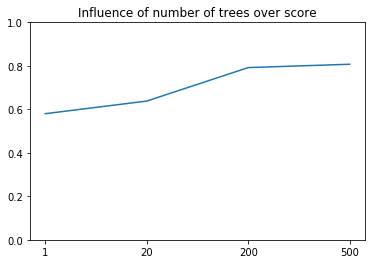

[0.58       0.638      0.792      0.80733333]


In [41]:
plt.ylim([0,1])
plt.plot(['1','20','200','500'],np.array(randomForest_gridSearch.cv_results_['mean_test_score'][:4]),)
plt.title("Influence of number of trees over score")
plt.show()
print(np.array(randomForest_gridSearch.cv_results_['mean_test_score'][:4]))

In this case, we can see that a higher amount of trees in the forest leads to a better model.<br>
This isn't a surprising conclusion when we look at the way random forests are built.<br>
We usually stop adding trees to the forest when the score becomes stable. Here it looks like there is no big difference between 200 and 500, so we stop there.


Below we can see the most important features of the model.<br>

In [42]:
pandas.DataFrame(randomForest_gridSearch.best_estimator_.steps[2][1].feature_importances_,index = randomForest_gridSearch.best_estimator_.steps[0][1].get_feature_names(),columns=['importance']).sort_values('importance', ascending=False).head(18)

importance
bad           0.006645
worst         0.005901
waste         0.003721
plot          0.003505
reason        0.003154
script        0.003090
life          0.003086
ridiculous    0.002874
looks         0.002682
great         0.002677
stupid        0.002664
boring        0.002630
just          0.002521
mess          0.002498
movie         0.002459
awful         0.002455
poorly        0.002278
terrible      0.002256

It is interesting to notice that almost all of these words have a clear positive or negative connotation.<br>
Another interesting observation is that most have negative meanings, so it looks like negative words have more impact on the advice than positive ones.

# Third model : Support Vector Machine (SVM)
In this section, we are going to see study the efficiency of the SVM algorithm to classify our data
We are first going to vectorize the data, using two different algorithms, the CountVectorizer, which simply counts the occurences of a word through all the files, and the Tf-IdfVectorizer which is slightly more complex, which focuses on the information carried by words. Then we will train our SVM and try to predict the test set and study the effects of the C parameter.

### Training with data and getting optimal parameters using gridsearch

In [45]:
# fit with the training set
%time svm_gridSearch = svm_gridSearch.fit(X_train, Y_train)

CPU times: user 28.7 s, sys: 327 ms, total: 29.1 s
Wall time: 3min 2s


We can see all the different models trained by the grid, and the results:

In [46]:
pandas.DataFrame(svm_gridSearch.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_SVM__C  \
0       25.681094      0.294199         3.096286        0.003165            1   
1       25.706869      0.272512         3.097992        0.007805            1   
2       25.256947      0.303036         2.829137        0.014990            1   
3       23.913162      0.233372         2.715463        0.026726            1   
4       25.852828      0.328411         2.763166        0.028118            1   
5       24.366312      1.292939         2.771117        0.023743            1   
6       23.605365      0.246154         2.718410        0.030870         1000   
7       20.871359      0.091955         2.531727        0.039009         1000   
8       23.941775      0.188324         2.698299        0.037069         1000   
9       22.483091      0.082059         2.283167        0.047250         1000   
10      21.690131      2.998047         2.487250        0.398412         1000   
11      17.108155      0.338221         1.930694        0.025098         1000   

   param_SVM__gamma param_SVM__kernel param_SVM__probability  \
0             0.001               rbf                   True   
1             0.001               rbf                   True   
2             0.001            linear                   True   
3             0.001            linear                   True   
4             0.001              poly                   True   
5             0.001              poly                   True   
6             0.001               rbf                   True   
7             0.001               rbf                   True   
8             0.001            linear                   True   
9             0.001            linear                   True   
10            0.001              poly                   True   
11            0.001              poly                   True   

   param_tfidf__use_idf                                             params  \
0                  True  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
1                 False  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
2                  True  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
3                 False  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
4                  True  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
5                 False  {'SVM__C': 1, 'SVM__gamma': 0.001, 'SVM__kerne...   
6                  True  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   
7                 False  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   
8                  True  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   
9                 False  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   
10                 True  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   
11                False  {'SVM__C': 1000, 'SVM__gamma': 0.001, 'SVM__ke...   

         ...         split1_test_score  split2_test_score  mean_test_score  \
0        ...                     0.500           0.501002         0.500667   
1        ...                     0.500           0.501002         0.500667   
2        ...                     0.850           0.833667         0.826000   
3        ...                     0.762           0.769539         0.753333   
4        ...                     0.500           0.501002         0.500667   
5        ...                     0.500           0.501002         0.500667   
6        ...                     0.854           0.835671         0.828000   
7        ...                     0.806           0.815631         0.797333   
8        ...                     0.844           0.837675         0.824667   
9        ...                     0.814           0.823647         0.804667   
10       ...                     0.500           0.501002         0.500667   
11       ...                     0.500           0.501002         0.500667   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0       

## Testing with the test set and measuring results

We start by predicting opinions on the test set.

In [47]:
%time svm_predictions = svm_gridSearch.predict(X_test)

CPU times: user 1.88 s, sys: 7.63 ms, total: 1.88 s
Wall time: 1.88 s


The best model has the following parameters:

In [73]:

print("\nbest params:")
for param_name in sorted(svm_parameters.keys()):
    print("\t%s: %r" % (param_name, svm_gridSearch.best_params_[param_name]))



best params:
	SVM__C: 1000
	SVM__gamma: 0.001
	SVM__kernel: 'rbf'
	SVM__probability: True
	tfidf__use_idf: True


It is interesting to see that english stopwords have not been chosen.<br>
The C value is the inverse of the regularisation strength. In our case, it is neither the higher nor the lower value.<br>
This is understandable because if the regalurisation strength is too high, we won't take the values into account as it should be, while with a low value, we tend to overfit the data.<br>
Finally, it is preferable to use idf in order not to give too much importance to the terms that appear in a lot of documents.

We can look at the individual metrics (we'll compare them with the other models later):

The confusion matrix of the prediction:

In [91]:
svm_confusion_matrix = metrics.confusion_matrix(Y_test, svm_predictions)
pandas.DataFrame(svm_confusion_matrix)


0    1
0  213   38
1   31  218

In [75]:
print("Accuracy: " + str(metrics.accuracy_score(Y_test,svm_predictions)))
print("Recall: " + str(metrics.recall_score(Y_test,svm_predictions)) )
print("Precision; " + str(metrics.precision_score(Y_test,svm_predictions)) )

Accuracy: 0.862
Recall: 0.8755020080321285
Precision; 0.8515625


# Comparision with or without TF-IDF using SVM
In this section, we are going to see study the efficiency of the SVM algorithm to classify our data
We are first going to vectorize the data, using two different algorithms, the CountVectorizer, which simply counts the occurences of a word through all the files, and the Tf-IdfVectorizer which is slightly more complex, which focuses on the information carried by words. Then we will train our SVM and try to predict the test set and study the effects of the C parameter.

### Creating the CountVectorizer sets

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_count = CountVectorizer()
vectorizer_count.fit(dataOpinions.data)

X_train_count = vectorizer_count.transform(X_train)
X_test_count = vectorizer_count.transform(X_test)

### Creating the Tf-IdfVectorizer sets

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(dataOpinions.data)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

### Training the two sets and predicting the test sets

In [53]:
from sklearn import svm

clf_count = svm.SVC(gamma=0.001, C=1000., probability=True)
%time clf_count.fit(X_train_count,Y_train)

CPU times: user 28.9 s, sys: 77.2 ms, total: 29 s
Wall time: 29.1 s


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
clf_tfidf = svm.SVC(gamma=0.001, C=1000., probability=True)
%time clf_tfidf.fit(X_train_tfidf,Y_train)

CPU times: user 27.6 s, sys: 22.2 ms, total: 27.7 s
Wall time: 27.7 s


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prediction on the test set:

In [55]:
%time prediction_count = clf_count.predict(X_test_count)

CPU times: user 1.9 s, sys: 7.89 ms, total: 1.91 s
Wall time: 1.91 s


In [56]:
%time prediction_tfidf = clf_tfidf.predict(X_test_tfidf)

CPU times: user 1.73 s, sys: 10.2 ms, total: 1.74 s
Wall time: 1.75 s


### Creating the CountVectorizer sets

In [57]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_count = CountVectorizer()
vectorizer_count.fit(dataOpinions.data)

X_train_count = vectorizer_count.transform(X_train)
X_test_count = vectorizer_count.transform(X_test)

### Creating the Tf-IdfVectorizer sets

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer()
vectorizer_tfidf.fit(dataOpinions.data)

X_train_tfidf = vectorizer_tfidf.transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

### Training the two sets and predicting the test sets

In [59]:
from sklearn import svm

clf_count = svm.SVC(gamma=0.001, C=1000., probability=True)
%time clf_count.fit(X_train_count,Y_train)

CPU times: user 29.3 s, sys: 95.3 ms, total: 29.4 s
Wall time: 29.5 s


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
clf_tfidf = svm.SVC(gamma=0.001, C=1000., probability=True)
%time clf_tfidf.fit(X_train_tfidf,Y_train)

CPU times: user 28 s, sys: 55 ms, total: 28 s
Wall time: 28.1 s


SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prediction on the test set:

In [61]:
%time prediction_count = clf_count.predict(X_test_count)

CPU times: user 1.9 s, sys: 7.94 ms, total: 1.91 s
Wall time: 1.91 s


In [62]:
%time prediction_tfidf = clf_tfidf.predict(X_test_tfidf)

CPU times: user 1.72 s, sys: 9.95 ms, total: 1.73 s
Wall time: 1.73 s


### Analyzing the predictions

Confusion matrix for both models:

In [77]:
cm_svm_count = metrics.confusion_matrix(Y_test, prediction_count)
print("prediction count:")
pandas.DataFrame(cm_svm_count)

prediction count:


0    1
0  195   56
1   39  210

In [78]:
print("prediction tfidf:")
cm_svm_tfidf = metrics.confusion_matrix(Y_test, prediction_tfidf)
pandas.DataFrame(cm_svm_tfidf)

prediction tfidf:


0    1
0  217   34
1   31  218

We can clearly see with the above two matrix that the model using tfidf is much more reliable.

In [79]:
print("Accuracy of Count - " + str(metrics.accuracy_score(Y_test,prediction_count)))
print("Accuracy of Tf-Idf - " + str(metrics.accuracy_score(Y_test,prediction_tfidf))+"\n")

print("Recall of Count - " + str(metrics.recall_score(Y_test, prediction_count)) )
print("Recall of Tf-Idf - " + str(metrics.recall_score(Y_test, prediction_tfidf)) +"\n")

print("Precision of Count - " + str(metrics.precision_score(Y_test, prediction_count)) )
print("Precision of Tf-Idf - " + str(metrics.precision_score(Y_test, prediction_tfidf)) )

Accuracy of Count - 0.81
Accuracy of Tf-Idf - 0.87

Recall of Count - 0.8433734939759037
Recall of Tf-Idf - 0.8755020080321285

Precision of Count - 0.7894736842105263
Precision of Tf-Idf - 0.8650793650793651


### Drawing a ROC figure

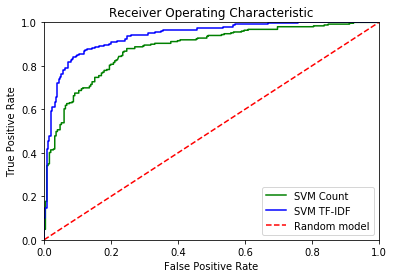

In [80]:
Y_pred_svm_count = clf_count.predict_proba(X_test_count)[:,1]
Y_pred_svm_tfidf = clf_tfidf.predict_proba(X_test_tfidf)[:,1]


plt.title('Receiver Operating Characteristic')
tpr3, fpr3, th3 = roc_curve(Y_test, Y_pred_svm_count)
tpr4, fpr4, th4 = roc_curve(Y_test, Y_pred_svm_tfidf)


plt.plot(tpr3, fpr3, 'g',label="SVM Count")
plt.plot(tpr4, fpr4, 'b',label="SVM TF-IDF")



plt.plot([0,1],[0,1],'r--', label="Random model")
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

First, both these model seem quite accurate when we look at their roc curve.<br>
By comparing the two curves, we also clearly see that the SVM using TF IDF is better than the other one.

# Evaluation and comparison of our different models

### Score

First, let's look at the score of each model:

In [82]:
print("Random forest score: " + str(randomForest_gridSearch.score(X_test,Y_test)))
print("Logistic regression score:" + str(logReg_gridSearch.best_score_))  
print("Accuracy of SVM: " + str(svm_gridSearch.score(X_test, Y_test)))

Random forest score: 0.826
Logistic regression score:0.8306666666666667
Accuracy of SVM: 0.862


As the documentation specifies, this score function is classifier specific.<br>
At first glance, it looks like SVM is the best model of the three we made.<br>
Let's look at some more specific metrics to verify that.

### Confusion matrix

The following plots show the confusion matrix of each model.<br>
On the diagonal we can see the correctly classified values.<br>
The better the model, the darker the diagonal should be, and the lighter the false prediction cells.

Confusion matrix, without normalization
[[217  34]
 [ 30 219]]


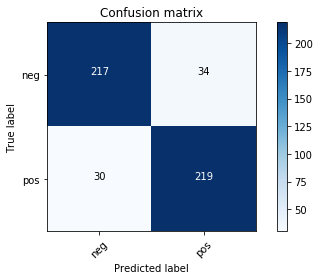

In [87]:
# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
plot_confusion_matrix(logReg_confusion_matrix, dataOpinions.target_names)
plt.show()

Confusion matrix, without normalization
[[217  34]
 [ 30 219]]


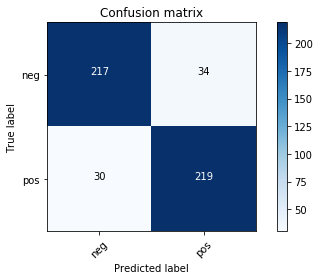

In [88]:
plot_confusion_matrix(logReg_confusion_matrix, dataOpinions.target_names)
plt.show()

Confusion matrix, without normalization
[[213  38]
 [ 31 218]]


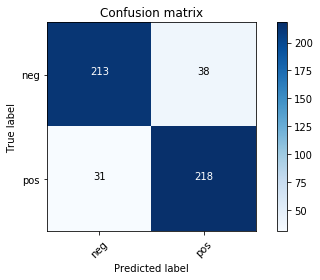

In [92]:
plot_confusion_matrix(svm_confusion_matrix, dataOpinions.target_names)
plt.show()

All the models have a majority of correctly classified examples, either positive or negative.<br>
However, two of them are slightly better: SVM with tf_idf and logistic regression.

### Accuracy score:
$ accuracy=\frac{TP+TN}{S} $<br>
Another interesting score is the accuracy score.<br>
It is calculated by dividing the amount of correctly classified elements by the number of total element.<br>
Here we can see that SVM with tf-idf comes first:

In [95]:
print("Random forest accuracy: "+ str(metrics.accuracy_score(Y_test, randomForest_predictions)))
print("Logistic regression accuracy: "+ str(metrics.accuracy_score(Y_test, logReg_predictions)))
print("Accuracy of SVM with Tf-Idf: " + str(metrics.accuracy_score(Y_test, svm_predictions)) +"\n")

Random forest accuracy: 0.826
Logistic regression accuracy: 0.872
Accuracy of SVM with Tf-Idf: 0.862



### Recall

$ recall=\frac{TP}{POS} $<br>
The recall describes the amount of positive examples correctly classified.<br>
That time, random forest is clearly the last one, and SVM is in slightly better than Logistic regression:

In [96]:
print("Random forest recall: "+ str(metrics.recall_score(Y_test, randomForest_predictions)))
print("Logistic regression recall: "+ str(metrics.recall_score(Y_test, logReg_predictions)))
print("Recall of SVM with Tf-Idf: " + str(metrics.recall_score(Y_test, svm_predictions)) +"\n")

Random forest recall: 0.7911646586345381
Logistic regression recall: 0.8795180722891566
Recall of SVM with Tf-Idf: 0.8755020080321285



### Precision

$ precision=\frac{TP}{PPOS} $<br>
Precision describes the amount of positively predicted testing examples that are really positive.<br>
    As for the previous metrics, logistic regression and SVM slightly over random forest, even if all three are very close.

In [97]:
print("Random forest recall: "+ str(metrics.precision_score(Y_test, randomForest_predictions)))
print("Logistic regression recall: "+ str(metrics.precision_score(Y_test, logReg_predictions)))
print("Precision of SVM with Tf-Idf: " + str(metrics.precision_score(Y_test, svm_predictions)) )

Random forest recall: 0.8491379310344828
Logistic regression recall: 0.8656126482213439
Precision of SVM with Tf-Idf: 0.8515625


### ROC Curve:

The ROC curve is a good way to compare models.<br>
It is built by comparing the true positive and false positive rates for different thresholds.

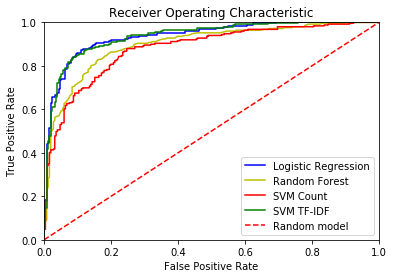

In [99]:
Y_pred_logReg = logReg_gridSearch.predict_proba(X_test)[:,1]
Y_pred_Rf = randomForest_gridSearch.predict_proba(X_test)[:,1]
Y_pred_svm_count = clf_count.predict_proba(X_test_count)[:,1]
Y_pred_svm_tfidf = clf_tfidf.predict_proba(X_test_tfidf)[:,1]


plt.title('Receiver Operating Characteristic')
tpr, fpr, th = roc_curve(Y_test,Y_pred_logReg)
tpr2, fpr2, th2 = roc_curve(Y_test, Y_pred_Rf)
tpr3, fpr3, th3 = roc_curve(Y_test, Y_pred_svm_count)
tpr4, fpr4, th4 = roc_curve(Y_test, Y_pred_svm_tfidf)



plt.plot(tpr,fpr, 'b',label="Logistic Regression")
plt.plot(tpr2, fpr2, 'y',label="Random Forest")
plt.plot(tpr3, fpr3, 'r',label="SVM Count")
plt.plot(tpr4, fpr4, 'g',label="SVM TF-IDF")



plt.plot([0,1],[0,1],'r--', label="Random model")
plt.legend(loc='lower right')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

On this plot those models are accurate on the test set.<br>
Graphically, one can say that logistic regression and SVM with tf-idf appear to be better models than random forest, which is confirmed when we calculate the area under the ROC curve:

In [101]:
print("AUC for Random Forest: "+str(metrics.roc_auc_score(Y_test,randomForest_predictions)))
print("AUC for Logistic regression: "+ str(metrics.roc_auc_score(Y_test,Y_pred_logReg)))
print("AUC for SVM with tf-idf: "+ str(metrics.roc_auc_score(Y_test, Y_pred_svm_tfidf)))


AUC for Random Forest: 0.8258612137794206
AUC for Logistic regression: 0.937054992879886
AUC for SVM with tf-idf: 0.9372949967199475


AUC of random forest is quite behind the other two models.<br>
Logistic regression and SVM are almost equal, SVM being ahead.<br>

### Training and prediction duration:

It is also interesting to compare the duration of the training and prediction steps of our models.<br>
We used a small dataset, so the differences won't be too noticeable, but these models could be used for much larger projects, in which time could be an issue.

### Logistic regression:
##### training:
CPU times: user 3.03 s, sys: 2.83 s, total: 5.85 s<br>
Wall time: 1min 28s
##### testing:
CPU times: user 310 ms, sys: 56.3 ms, total: 366 ms<br>
Wall time: 287 ms

### Random forest:
##### training:
CPU times: user 7.06 s, sys: 127 ms, total: 7.18 s<br>
Wall time: 44.6 s
##### testing:
CPU times: user 447 ms, sys: 1.61 ms, total: 448 ms<br>
Wall time: 447 ms

### SVM

##### training:
CPU times: user 30.9 s, sys: 0 ns, total: 30.9 s<br>
Wall time: 30.9 s
##### testing:
CPU times: user 1.69 s, sys: 0 ns, total: 1.69 s<br>
Wall time: 1.69 s

We can now compare both the time needed for training, and to make predictions on the test set:

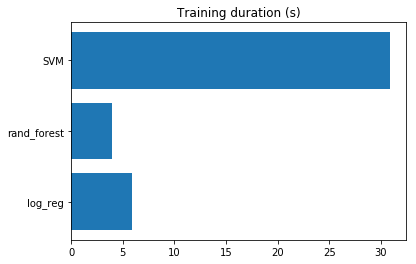

In [102]:
plt.barh(["log_reg","rand_forest","SVM"],[5.85, 4., 30.9])
plt.title("Training duration (s)")
plt.show()

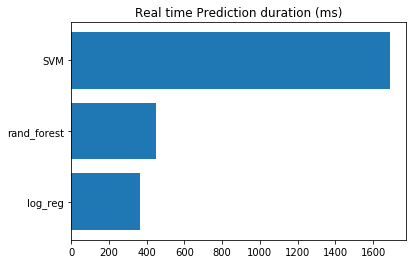

In [103]:
plt.barh(["log_reg","rand_forest","SVM"],[366, 448, 1690])
plt.title("Real time Prediction duration (ms)")
plt.show()

#### Analysis

The SVM model is the more accurate but it has one drawback. To train a single model it took 30 seconds whereas all the others took less than 10 seconds per model. (we used pipelines for the others so the real time is the total time to train all models)<br>
The testing duration is also more important for SVM.<br>
It takes more than one and a half second to predict on the test set whereas the two other models only need around 500ms.<br>

All these durations are quite short on the dataset we used however if we used the larger dataset, the difference in time between SVM and the two others could become very significant and result in a huge loss of time.

# Conclusion

First, we've seen how to represent textual data by transforming it into numerical vectors.<br>
Then, we tried three different models to fit the problem.<br>
As we've seen, all of them have had interesting results for the time consumed in training.<br>
We tuned some parameters for each of them, and saw how it could affect the accuracy of the model.<br>
If we had to compare the three models in term of results, the SVM comes first. It is the model with the best score, and the best area under the ROC curve.<br>
But we should also take into acount the time needed to train our models. And in this case, the SVM might be a problem with much larger datasets.
In case time is a problem, logistic regression could be a better solution in term of time and efficiency.

# Used sources

Examples given in class<br>
sklearn's documentation<br>
https://zablo.net/blog/post/twitter-sentiment-analysis-python-scikit-word2vec-nltk-xgboost<br>
http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html<br>
https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019<br>
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html